# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint


# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
# Documentation found at https://github.com/wingchen/citipy
# this may require a pip install citipy 
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"


## Generate Cities List

In [2]:
# Range of latitudes and longitudes - Stored in tuples
lat_range = (-90, 90)
lng_range = (-180, 180)

In [3]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

610

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
url = "http://api.openweathermap.org/data/2.5/weather?"

# Build query URL - included imperial unit conversion to get degrees Fahrenheit and wind speed in miles/hour
query_url = url + "units=imperial&appid=" + weather_api_key + "&q="

In [5]:
#Picked a random local city to see information available in the JSON

response = requests.get(query_url + "san antonio").json()
pprint(response)

{'base': 'stations',
 'clouds': {'all': 0},
 'cod': 200,
 'coord': {'lat': 29.4241, 'lon': -98.4936},
 'dt': 1659452715,
 'id': 4726206,
 'main': {'feels_like': 91.87,
          'humidity': 62,
          'pressure': 1017,
          'temp': 86.02,
          'temp_max': 89.06,
          'temp_min': 83.8},
 'name': 'San Antonio',
 'sys': {'country': 'US',
         'id': 2003611,
         'sunrise': 1659441276,
         'sunset': 1659489945,
         'type': 2},
 'timezone': -18000,
 'visibility': 10000,
 'weather': [{'description': 'clear sky',
              'icon': '01d',
              'id': 800,
              'main': 'Clear'}],
 'wind': {'deg': 160, 'speed': 14.97}}


In [6]:
#List of the information that needs to be captured for each city

lat =[]      # List of Latitudes
lng = []     # List of Longitudes
temp =[]     # List of Temperatures
humid = []   # List of Humidity Values (%)
cloud = []   # List of Cloudiness (%)
wind = []    # List of Wind Speed (mph)
city_id = [] # List of city ID number
city_name = [] # List with the proper captialization of the city's name
date_of_pull = []
country = []

removed_cities = [] # getting a list of missing cities

for city in cities:
    try:
        response = requests.get(query_url + city).json()
        city_name.append(response['name'])
        country.append(response['sys']['country'])
        date_of_pull.append(response['dt'])
        lat.append(response['coord']['lat'])
        lng.append(response['coord']['lon'])
        temp.append(response['main']['temp_max'])    # adding temperature data
        humid.append(response['main']['humidity'])   # adding humidity data
        cloud.append(response['clouds']['all'])
        wind.append(response['wind']['speed'])
        city_id.append(cities.index(city))
        
    except:
        #Cities with failed responses will be removed later 
        # but stored in removed_cities until then
        removed_cities.append(city)
        
     
#==PRINT OUT OF CURRENT STATUS OF THE LISTS===

print("INFORMATION ON REMOVED CITIES")
print(f'Current count of the city list is {len(cities)}')
print(f'Number of cities removed: {len(removed_cities)}')


INFORMATION ON REMOVED CITIES
Current count of the city list is 610
Number of cities removed: 44


In [7]:
#Sample of the removed cities list

for num in range(3):
    print(removed_cities[num])

barentsburg
saleaula
westpunt


In [10]:
#Remove the failed cities captured in the removed list from the cities list
count = len(cities)

print(f'Length of cities before {count}')

for r_city in removed_cities:
    cities.remove(r_city)
    
print(f'Length of cities after {len(cities)} should be the same as first count of the cities list')
print(f'less the count of the removed list: {count - len(removed_cities)}.')

Length of cities before 610
Length of cities after 566 should be the same as first count of the cities list
less the count of the removed list: 566.


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [32]:
# create a data frame from cities, lat, and temp

weather_dict = {
    "City ID": city_id,
    "City Name": city_name,
    "Cloudiness":cloud,
    "Country": country,
    "Date of Request": date_of_pull,
    "Humidity": humid,
    "Latitude": lat,
    "Longitude":lng,    
    "Temperature": temp,
    "Wind Speed": wind
}

city_data = pd.DataFrame(weather_dict)

# Below Did not work
#city_data["Date of Request"] = pd.to_datetime(city_data["Date of Request"]) #Testing converting time from UNIX

city_data.head()

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Norman Wells,99,CA,1659452959,54,65.2820,-126.8329,58.08,3.96
1,1,Busselton,92,AU,1659452823,69,-33.6500,115.3333,51.55,30.94
2,2,Amapá,3,BR,1659452959,53,1.0000,-52.0000,88.38,4.85
3,3,Mataura,84,NZ,1659452960,87,-46.1927,168.8643,44.47,8.90
4,5,Thompson,100,CA,1659452822,100,55.7435,-97.8558,55.56,0.00


In [12]:
#Exporting the city data to a CSV file
city_data.to_csv(output_data_file, encoding ="utf-8", index = False, header = True)

## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [ ]:
## FOR REMOVAL IF COMBINED IF WORKS
### == IF KEEPING MANUAL COPY
clean_city_data = city_data.copy()

In [ ]:
## FOR REMOVAL IF COMBINED IF WORKS
### == IF KEEPING MANUAL COPY
#Capture cities with humidity greater than 100% and remove from the dataframe

humid_101 = clean_city_data.loc[(clean_city_data["Humidity"]>100),:]
len(humid_101) #===== TEST AREA ======== Should be a display instead


In [33]:
###===== TEST AREA ========
#CHECKING IF THERE ARE ANY WITH HUMIDITY
(city_data["Humidity"]>100).value_counts()

False    566
Name: Humidity, dtype: int64

In [34]:
###===== TEST AREA ========
#==if there are no humid data in city_data, then add 2==
# These 2 were previously removed because they are not cities 
print(f'Before Add Length {len(city_data)}')

yelloknife_list= [1000, 'yellowknife',30,'JA',1659296902,102,62.4560,-114.3525,63.12,4.61]
saintphil_list = [1001, 'saint-philippe',30,'JA',1659296902,103,62.4560,-114.3525,63.12,4.61]

city_data.loc[len(city_data.index)] = yelloknife_list
city_data.loc[len(city_data.index)]=saintphil_list
print(f'After Add Length {len(city_data)}')
#===== TEST AREA ========

Before Add Length 566
After Add Length 568


In [35]:
###===== TEST AREA ========
#CHECKING IF THERE ARE ANY WITH HUMIDITY - AFTER ADD
(city_data["Humidity"]>100).value_counts()

False    566
True       2
Name: Humidity, dtype: int64

In [36]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".


#Capture cities with humidity greater than 100% and remove from the dataframe
humid_101 = city_data.loc[(city_data["Humidity"]>100),:]
clean_city_data = pd.DataFrame()
count=0

for count in humid_101.index:
    if len(humid_101.index)>0:
        clean_city_data = city_data.drop(index = count, errors = 'ignore')
        count += 1
    else:
        clean_city_data = city_data.copy()
        print("I'm in the else block, why?")

print(f'Total removed: {count}')

Total removed: 568


In [ ]:
## FOR REMOVAL IF COMBINED IF WORKS

#===== MIGHT KEEP FOR BELOW OR REMOVE ALL TOGETHER ========
#===========================================================
#  Get the indices of cities that have humidity over 100%.
indicies = humid_101.index  # This is a test
indicies

In [ ]:
## FOR REMOVAL IF COMBINED IF WORKS
#===== TESTING THE REMOVAL OF HUMID VALUES ========
#GOING TO COPY CITY_DATA INTO CLEAN_CITY_DATA FOR USE IN NEXT SECTIONS

for count in humid_101.index:
    clean_city_data = clean_city_data.drop(index = count, errors = 'ignore', inplace=False)
    print(count)
    #print(humid_101.index(count))

#humid_101

In [37]:
###===== TEST AREA ========
len(clean_city_data)

567

In [38]:
###===== TEST AREA ========
clean_city_data.tail()

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
562,606,Zacualpan,100,MX,1659453169,83,21.2500,-105.1667,85.62,5.99
563,607,Priponeşti,81,RO,1659453170,42,46.0833,27.4333,80.04,15.84
564,608,Tougan,56,BF,1659453170,49,13.0667,-3.0667,88.79,6.02
565,609,Chara,9,RU,1659453170,66,56.9064,118.2631,64.42,1.25
566,1000,yellowknife,30,JA,1659296902,102,62.4560,-114.3525,63.12,4.61


In [22]:
humid_101.index

Int64Index([566, 567], dtype='int64')

In [ ]:
for count in humid_101.index:
    clean_city_data = clean_city_data.drop(index = count, errors = 'ignore', inplace=False)
    print(count)

In [39]:
city_data.tail()

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
563,607,Priponeşti,81,RO,1659453170,42,46.0833,27.4333,80.04,15.84
564,608,Tougan,56,BF,1659453170,49,13.0667,-3.0667,88.79,6.02
565,609,Chara,9,RU,1659453170,66,56.9064,118.2631,64.42,1.25
566,1000,yellowknife,30,JA,1659296902,102,62.4560,-114.3525,63.12,4.61
567,1001,saint-philippe,30,JA,1659296902,103,62.4560,-114.3525,63.12,4.61


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

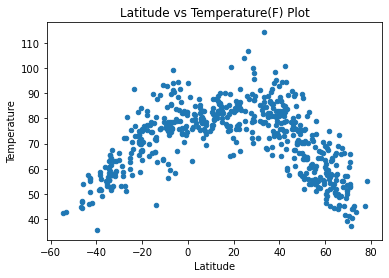

In [40]:
#should be clean_city_data... testing with city_data

lat_temp_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                              y = "Temperature",
                                              facecolors ="red",
                                              title="Latitude vs Temperature(F) Plot")
#plt.ylim(33, 47) # to be checked
#plt.xlim (14,26) #to be checked
plt.show(lat_temp_plot)



**Assessment of the Latitude vs Temperature Plot**

Regardless of the cities used for this scatter plot, the data will confirm that locations/cities within between -23.5 to 23.5 degrees Latitude with have higher temperatures. Those cities lie in the Torrid Zone of the earth, those cities closer to the equator being hotter.

## Latitude vs. Humidity Plot

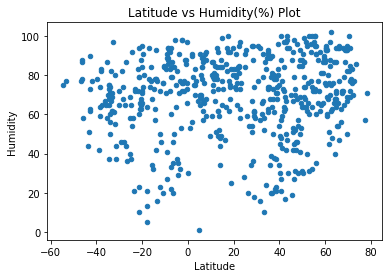

In [41]:
lat_humid_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Humidity",
                                        facecolors ="red",
                                        title="Latitude vs Humidity(%) Plot")
#plt.ylim(33, 47) # to be checked
#plt.xlim (14,26) #to be checked
plt.show(lat_humid_plot)

**Assessment of the Latitude vs Humidity Plot**



## Latitude vs. Cloudiness Plot

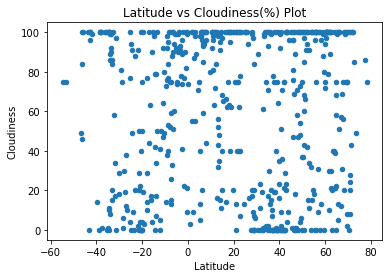

In [42]:
lat_cloud_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Cloudiness",
                                        facecolors ="red",
                                        title="Latitude vs Cloudiness(%) Plot")
#plt.ylim(33, 47) # to be checked
#plt.xlim (14,26) #to be checked
plt.show(lat_cloud_plot)

**Assessment of the Latitude vs Cloudiness Plot**

Based on the data there is no correlation between Latitude and Cloudiness conditions. For this reason you will find cloudiness throughout the dataset.

## Latitude vs. Wind Speed Plot

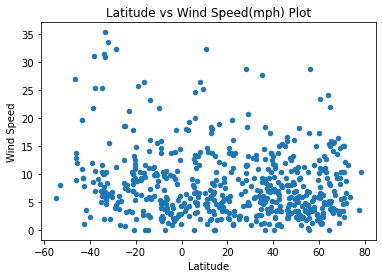

In [43]:
lat_wind_plot = clean_city_data.plot.scatter(x = "Latitude", 
                                        y = "Wind Speed",
                                        facecolors ="red",
                                        title="Latitude vs Wind Speed(mph) Plot")
#plt.ylim(33, 47) # to be checked
#plt.xlim (14,26) #to be checked
plt.show(lat_wind_plot)

**Assessment of the Latitude vs Wind Speed Plot**

Like assessment of the Latitude vs Cloudiness, the data to show the relationship between Latitude and Wind Speed conditions shows no correlation of one to the other.

## Linear Regression

In [45]:
clean_city_data.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Norman Wells,99,CA,1659452959,54,65.282,-126.8329,58.08,3.96
1,1,Busselton,92,AU,1659452823,69,-33.650,115.3333,51.55,30.94


In [48]:
#Create 2 more dataframe from the clean_city_data

#Northern Hemisphere dataframe - cities with Latitude >= 0
north_hemi_df = clean_city_data.loc[(clean_city_data["Latitude"] >= 0), :]
north_hemi_df.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
0,0,Norman Wells,99,CA,1659452959,54,65.282,-126.8329,58.08,3.96
2,2,Amapá,3,BR,1659452959,53,1.000,-52.0000,88.38,4.85


In [49]:
#Southern Hemisphere dataframe - cities with Latitude < 0
south_hemi_df =clean_city_data.loc[(clean_city_data["Latitude"] < 0), :]
south_hemi_df.head(2)

,City ID,City Name,Cloudiness,Country,Date of Request,Humidity,Latitude,Longitude,Temperature,Wind Speed
1,1,Busselton,92,AU,1659452823,69,-33.6500,115.3333,51.55,30.94
3,3,Mataura,84,NZ,1659452960,87,-46.1927,168.8643,44.47,8.90


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

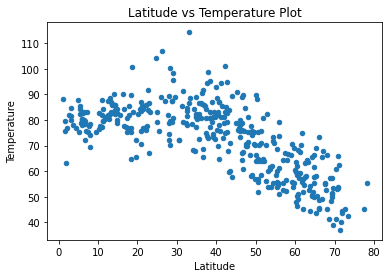

In [50]:
#should be clean_city_data... testing with city_data

north_lat_temp_plot = north_hemi_df.plot.scatter(x = "Latitude", 
                                              y = "Temperature",
                                              facecolors ="red",
                                              title="Latitude vs Temperature Plot")

plt.show(north_lat_temp_plot)

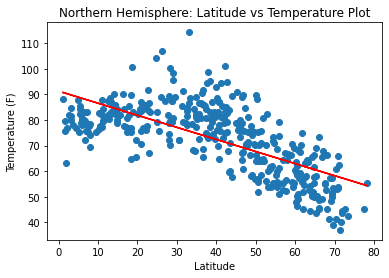

In [51]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Temperature Plot")
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.show()

## DELETE BEFORE SUBMITTING
final_plot = avg_tumor_weight_df.plot.scatter(x = "Weight (g)", 
                                              y = "Tumor Volume (mm3)",
                                              facecolors ="red",
                                              title="Average Tumor Volume per weight of Mouse")
plt.ylim(33, 47)
plt.xlim (14,26)
plt.show(final_plot)


**===========================================================**

**Add the linear regression equation and line to plot**
x_values = avg_tumor_weight_df["Weight (g)"]
y_values = avg_tumor_weight_df["Tumor Volume (mm3)"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(18,38),fontsize=15,color="red")
plt.title("Average Tumor Volume per weight of Mouse")
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

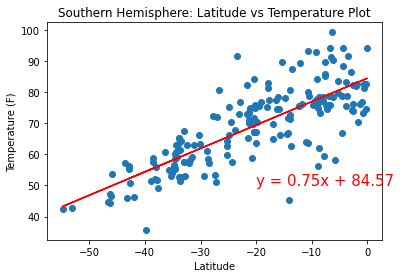

In [52]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Temperature Plot")
plt.xlabel('Latitude')
plt.ylabel('Temperature (F)')
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

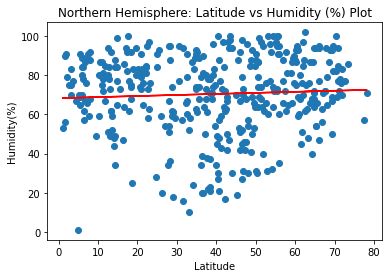

In [53]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Humidity (%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

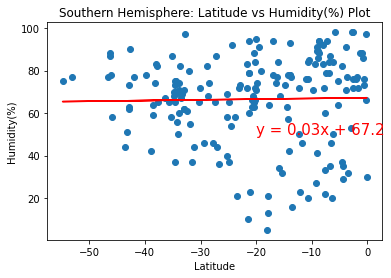

In [54]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Humidity(%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Humidity(%)')
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

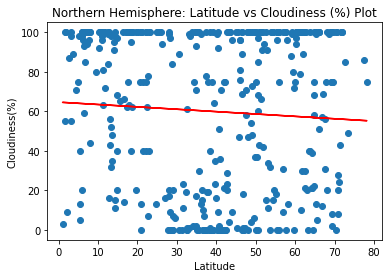

In [55]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Cloudiness (%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness(%)')
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

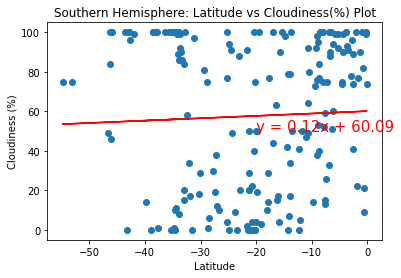

In [56]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Cloudiness(%) Plot")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

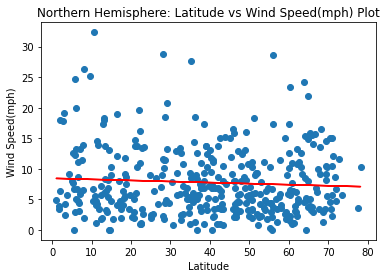

In [57]:
#Add the linear regression equation and line to plot
x_values = north_hemi_df["Latitude"]
y_values = north_hemi_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Northern Hemisphere: Latitude vs Wind Speed(mph) Plot")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed(mph)')
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

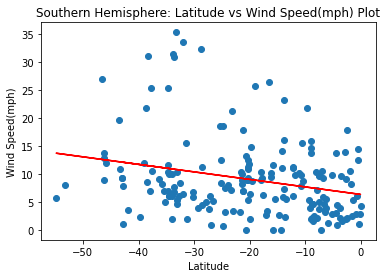

In [58]:
#Add the linear regression equation and line to plot
x_values = south_hemi_df["Latitude"]
y_values = south_hemi_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-20,50),fontsize=15,color="red")
plt.title("Southern Hemisphere: Latitude vs Wind Speed(mph) Plot")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed(mph)')
plt.show()